<a href="https://colab.research.google.com/github/changsin/FSDL/blob/main/notebooks/License_Plate_CPA_Clustering_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brazilean license plate dataset

The dataset came from: https://web.inf.ufpr.br/vri/databases/ufpr-alpr/


In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the data

## Methods

In [41]:
IMAGE_SIZE = 224

In [42]:
%matplotlib inline

from matplotlib import pyplot as plt

import cv2
import os
import glob
import numpy as np

In [43]:
from lxml import etree
import json

def to_json(path, data):
  """
  save json data to path
  """
  # y_yolov5_lists = y_yolov5.tolist()
  # json_str = json.dumps(y_yolov5_lists)
  with open(path, 'w', encoding='utf-8') as file:
      json.dump(data, file, ensure_ascii=False, indent=4)

def from_json(path):
  """
  save json data to path
  """
  file = open(path, 'r', encoding='utf-8')
  return json.load(file)

def resize_annotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)

    # y_yolov5 = np.array([to_yolov5(y) for y in y_train_raw])
    return [int(xmin), int(ymin), int(xmax), int(ymax)]

def extract_annotations(label_file, class_id):
  labels = []
  with open(label_file, "r") as file:
    count = 0
    for line in file:
      tokens = [float(token) for token in line.split()]
      if tokens[0] == class_id:
        count += 1
        # print(line)
        labels.append(np.array(tokens[1:]))

    if count > 1:
      print("WARNING: More than one license plate was found: ", count, label_file)
    elif count == 0:
      print("WARNING: No license plate was found: ", count, label_file)

  return np.array(labels)

def to_yolov5(y):
  """
  # change to yolo v5 format
  # https://github.com/ultralytics/yolov5/issues/12
  # [x_top_left, y_top_left, x_bottom_right, y_bottom_right] to
  # [x_center, y_center, width, height]
  """
  width = y[2] - y[0]
  height = y[3] - y[1]

  if width < 0 or height < 0:
    print("ERROR: negative width or height ", width, height, y)
    raise AssertionError("Negative width or height")
  return int(y[0] + (width/2)), int(y[1] + (height/2)), width, height

In [44]:
def load_images(path):
  path = os.path.join(path,'*')
  files = glob.glob(path)
  # We sort the images in alphabetical order to match them
  #  to the annotation files
  files.sort()

  X_raw = []
  for file in files:
    image = cv2.imread(file)
    image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))
    X_raw.append(np.array(image))

  return np.array(X_raw)

def load_labels(path, yolov5=True):
  """
  if path is an annotation file, just load it
  and return it immediately to save time
  """
  if path.endswith('.json'):
    return from_json(path)

  path = os.path.join(path,'*')
  files = glob.glob(path)
  files.sort()

  y_raw = []
  for file in files:
    if yolov5:
      y_raw.append(extract_annotations(file, 0))
    else:
      y_raw.append(resize_annotation(file))
  return np.array(y_raw)

In [45]:
# transform to arrays and normalize
def normalize(X_raw, y_raw):
  X = np.array(X_raw)
  y = np.array(y_raw)
  y = y.reshape((y.shape[0], -1))

  #  Renormalisation
  X = X / IMAGE_SIZE
  y = y / IMAGE_SIZE

  return X, y

In [46]:
import matplotlib.patches as patches

def create_patch_rectangle(y, color):
  # width = y[2] - y[0]
  # height = y[3] - y[1]
  # return patches.Rectangle((y[0], y[1]),
  #                           width, height,
  #                           edgecolor=color, fill=False)
  # # in yolov5
  width = int(y[2])
  height = int(y[3])
  return patches.Rectangle((int(y[0] - width/2), int(y[1] - height/2)),
                           width, height,
                           edgecolor=color, fill=False)
def plot_images(X, y, limit=10):
  fig = plt.figure(figsize=(20,40))

  # The number of images for plotting is limited to 50
  end_id = len(y) if len(y) < limit else limit

  for i in range(0, end_id):
    axis = fig.add_subplot(10, 5, i+1)
    plt.axis('off')
    image = X[i]

    rect_ori = create_patch_rectangle(y[i]*IMAGE_SIZE, (0, 255/255, 0))
    axis.add_patch(rect_ori)
    plt.imshow(np.clip(image, 0, 1))
# plot_images(X_train_d[0], y_train_d[0])

## Execution

### UFPR dataset

In [47]:
# DATA_ROOT = "./drive/MyDrive/data/UFPR_YOLO"

# X_train_raw = load_images(DATA_ROOT + "/images/train/")
# # X_test_raw = load_images(DATA_ROOT + "/images/test/")
# # X_val_raw = load_images(DATA_ROOT + "/images/validation/")

# y_train_raw = load_labels(DATA_ROOT + "/labels/train/")
# # y_val_raw = load_labels(DATA_ROOT + "/labels/validation/")
# # y_test_raw = load_labels(DATA_ROOT + "/labels/test/")

In [48]:
# # # from sklearn.model_selection import train_test_split
# # # TODO
# # X_train_raw = X_raw

# X_train, y_train = normalize(X_train_raw, y_train_raw)
# # X_val, y_val = normalize(X_val_raw, y_val_raw)
# # X_test, y_test = normalize(X_test_raw, y_test_raw)

### Kaggle dataset

In [49]:
DATA_ROOT = "./drive/MyDrive/data/Kaggle_license_plates"

X_train_raw = load_images(DATA_ROOT + "/images/")
y_train_raw = load_labels(DATA_ROOT + "/annotations.json")
X_train, y_train = normalize(X_train_raw, y_train_raw)

# Clustering

### Methods

#### PCA

In [50]:
from sklearn.decomposition import PCA

def get_pca(X_train, y_train):
  X_train_flatten = X_train.reshape(X_train.shape[0], -1)

  pca = PCA(2)

  X_train_pca = pca.fit_transform(X_train_flatten)

  # plot the scatter plot along the way
  plt.figure(1)
  plt.clf()

  plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap="Paired")
  plt.colorbar()

  return X_train_pca, pca

In [51]:
def get_pca_3d(X_train, y_train):
  X_train_flatten = X_train.reshape(X_train.shape[0], -1)

  pca = PCA(3)

  X_train_pca = pca.fit_transform(X_train_flatten)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  # ax = Axes3D(fig)

  ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1],  X_train_pca[:, 2],
              c=y_train, cmap="Paired")
  # ax.colorbar()

  return X_train_pca

In [129]:
from sklearn.cluster import KMeans

def get_clusters(X_train_pca, K):
  kmeans = KMeans(n_clusters=K, random_state=0)
  X_train_pca_clusters = kmeans.fit(X_train_pca)

  return X_train_pca_clusters, kmeans

def get_feature_map_clusters(X, K):
  """
  param X: input data
  param K: number of clusters
  returns: X_clusters - clustered input data

  (side effect): plots the frequency histogram of clusters
  """
  X_fm, _ = get_feature_maps(X)
  # use cosine distance to find similarities
  X_fm_normalized = preprocessing.normalize(X_fm.reshape(len(X_fm), -1))

  return get_clusters(X_fm_normalized)

def to_cluster_idx(bins, labels):
  """
  param bins: range of K
  param labels: cluster labels
  returns: dictionary of cluster IDs
  """
  cluster_dict = dict()
  for cluster_id in bins:
    cluster_dict[cluster_id] = np.where(labels == cluster_id)[0]
  return cluster_dict

def to_clusters_dict(X, y, X_clusters, K):
  """
  given X_clusters, put X & y into the correct clusters
  and return the dictionary
  """
  X_cluster_idx = to_cluster_idx(range(K), X_clusters.labels_)

  X_dict = {}
  y_dict = {}
  for id in range(K):
    ids = X_cluster_idx[id]
    X_dict[id] = X[ids]
    y_dict[id] = y[ids]

  return X_dict, y_dict

#### Plotting

In [53]:
def plot_cluster_histogram(X_clusters, K):
  histo_x, bins = np.histogram(X_clusters.labels_, bins=range(K + 1))
  plt.bar(bins[:-1], histo_x, align='center')

def plot_pca_clusters(X_train_pca, kmeans):
  # kmeans, X_train_pca_clusters = get_clusters(X_train_pca)

  # Step size of the mesh. Decrease to increase the quality of the VQ.
  h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

  # Plot the decision boundary. For that, we will assign a color to each
  x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
  y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Obtain labels for each point in mesh. Use last trained model.
  Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)

  plt.figure(2)
  # plt.clf()
  plt.imshow(Z, interpolation="nearest",
            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
            cmap=plt.cm.Paired, aspect="auto", origin="lower")

  plt.plot(X_train_pca[:, 0], X_train_pca[:, 1], 'k.', markersize=2)
  # Plot the centroids as a white X
  centroids = kmeans.cluster_centers_

  markers = ["o", "1", "2", "3", "4"]
  for id in range(len(centroids)):
    c = centroids[id]
    plt.scatter(c[0], c[1], marker=markers[id], s=169, linewidths=3,
                color="w", zorder=10)

  # plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
  #             color="w", zorder=10)
  # https://matplotlib.org/2.0.2/api/markers_api.html#module-matplotlib.markers
  plt.title("K-means clustering on the PCA-reduced data\n"
            "Centroids 0-o, 1-down, 2-up, 3-left, 4-right tri")
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.xticks(())
  plt.yticks(())
  plt.show()

In [54]:
def plot_data_in_clusters(X_train_pca, kmeans, idx):
  # kmeans, X_train_pca_clusters = get_clusters(X_train_pca)

  # Step size of the mesh. Decrease to increase the quality of the VQ.
  h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

  # Plot the decision boundary. For that, we will assign a color to each
  x_min, x_max = X_train_pca[:, 0].min() - 3, X_train_pca[:, 0].max() + 3
  y_min, y_max = X_train_pca[:, 1].min() - 3, X_train_pca[:, 1].max() + 3
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Obtain labels for each point in mesh. Use last trained model.
  Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)

  plt.figure(2)
  # plt.clf()
  plt.imshow(Z, interpolation="nearest",
            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
            cmap=plt.cm.Paired, aspect="auto", origin="lower")

  plt.plot(X_train_pca[:, 0], X_train_pca[:, 1], 'k.', markersize=2)
  # Plot the centroids as a white X
  # centroids = kmeans.cluster_centers_

  # markers = ["o", "1", "2", "3", "4"]
  # for id in range(len(centroids)):
  #   c = centroids[id]
  #   plt.scatter(c[0], c[1], marker=markers[id], s=169, linewidths=3,
  #               color="w", zorder=10)
  for id in idx:
    plt.scatter(X_train_pca[id, 0], X_train_pca[id, 1], marker="x",
                s=169, linewidths=3,
                color="w", zorder=10)

  # plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
  #             color="w", zorder=10)
  # https://matplotlib.org/2.0.2/api/markers_api.html#module-matplotlib.markers
  plt.title("K-means clustering on the PCA-reduced data\n"
            "Centroids 0-o, 1-down, 2-up, 3-left, 4-right tri")
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.xticks(())
  plt.yticks(())
  plt.show()

In [55]:
from sklearn.model_selection import train_test_split

def partition_on_clusters(X_d, y_d, bins, val_size=0.1, test_size=0.2):
  X_train_d = dict()
  y_train_d = dict()
  X_val_d = dict()
  y_val_d = dict()
  X_test_d = dict()
  y_test_d = dict()

  # for each cluster reserve test_size portion for test data
  for id in bins:
    Xt_train, Xt_test, yt_train, yt_test = \
      train_test_split(X_d[id], y_d[id], test_size=0.2, shuffle=False)
    Xt_train, Xt_val, yt_train, yt_val = \
      train_test_split(Xt_train, yt_train, test_size=0.1, shuffle=False)

    X_train_d[id] = Xt_train
    y_train_d[id] = yt_train

    X_val_d[id] = Xt_val
    y_val_d[id] = yt_val

    X_test_d[id] = Xt_test
    y_test_d[id] = yt_test

  return X_train_d, y_train_d, \
         X_val_d, y_val_d, \
         X_test_d, y_test_d

#### Find duplicates

In [146]:
from scipy.spatial.distance import cdist

def find_duplicates(X_train_pca):
  # Calculate distances of all points
  distances = cdist(X_train_pca, X_train_pca)

  # Find duplicates (very similar images)
  # dupes = np.array([np.where(distances[id] < 1) for id in range(distances.shape[0])]).reshape(-1)
  dupes = [np.array(np.where(distances[id] < 1)).reshape(-1).tolist() \
          for id in range(distances.shape[0])]

  to_remove = set()
  for d in dupes:
    if len(d) > 1:
      for id in range(1, len(d)):
        to_remove.add(d[id])
  print("Found {} duplicates".format(len(to_remove)))
  return to_remove

# # Remove self-comparison duplicates
# duplicates = [np.delete(dupes[id], np.where(dupes[id] == id)) for id in range(dupes.shape[0])]

# # duplicates
# to_mark = set()
# for id in range(len(duplicates)):
#   if len(duplicates[id]):
#     for e in duplicates[id]:
#       to_mark.add(e)
# len(to_mark)

### Execution

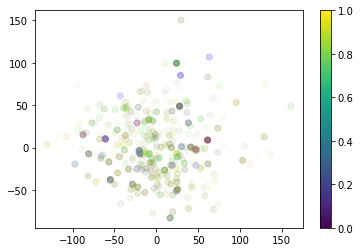

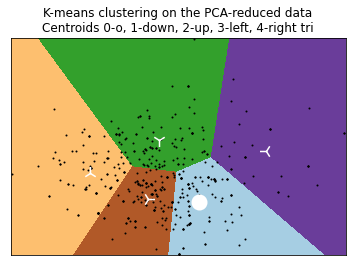

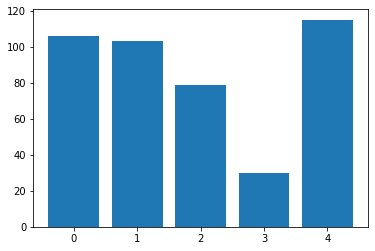

In [56]:
K = 5
X_train_pca, pca = get_pca(X_train, y_train)
X_train_pca_clusters, pca_kmeans = get_clusters(X_train_pca, K)
plot_pca_clusters(X_train_pca, pca_kmeans)
plot_cluster_histogram(X_train_pca_clusters, K)

From the plotted clusters, we can see that data points in Cluster #4 are quite similar while those in #3 are sparse and dissimilar. Let's see if this intuition is true. If we take a peek at two clusters, #3 is indeed more disparate while #4 is more homogenious.

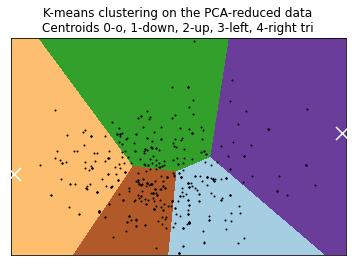

In [33]:
plot_data_in_clusters(X_train_pca, pca_kmeans, [188, 203])
# plot_data_in_clusters(X_train_pca, pca_kmeans, [100, 200])

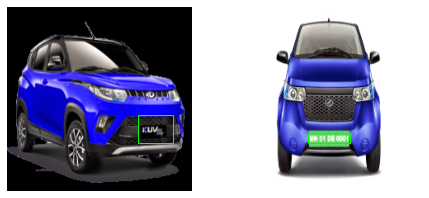

In [24]:
plot_images([X_train[188], X_train[203]], [y_train[188], y_train[203]])

## Plot all duplicate data points

In [147]:
to_remove = find_duplicates(X_train_pca)

Found 145 duplicates


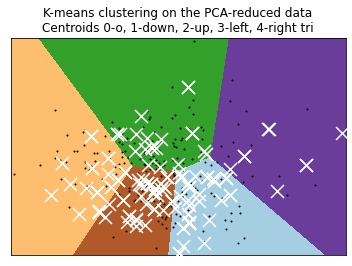

In [148]:
plot_data_in_clusters(X_train_pca, pca_kmeans, to_remove)

In [149]:
# count the number of duplicates in each cluster
X_train_idx = to_cluster_idx(range(K), X_train_pca_clusters.labels_)

for id in range(K):
  total_items = len(X_train_idx[id])
  dupe_count = len(set(X_train_idx[id]) & set(to_remove))
  print("{}: {:.2f}% {}/{}".format(id, 100*dupe_count/total_items, dupe_count, total_items))


0: 41.51% 44/106
1: 21.36% 22/103
2: 34.18% 27/79
3: 30.00% 9/30
4: 37.39% 43/115


In [61]:
X_train_d, y_train_d = to_clusters_dict(X_train, y_train, X_train_pca_clusters, K)

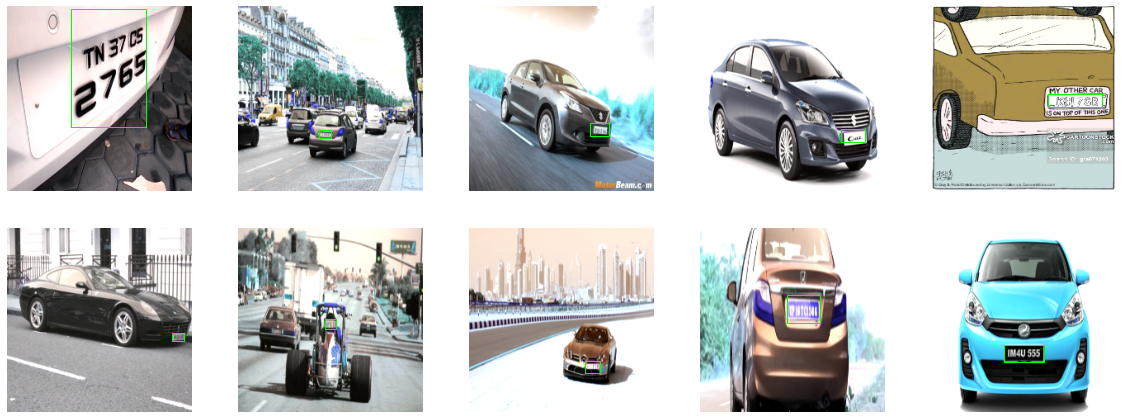

In [69]:
plot_images(X_train_d[3], y_train_d[3])

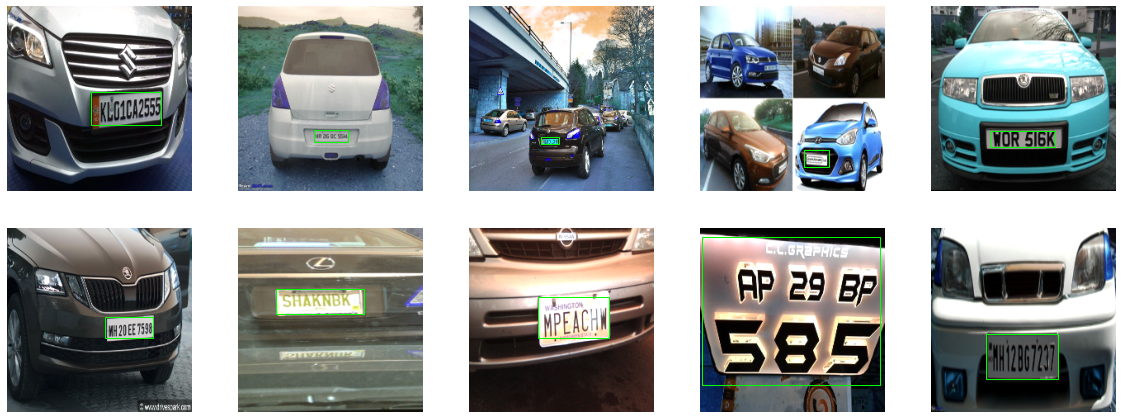

In [70]:
plot_images(X_train_d[4], y_train_d[4])

In [43]:
def find_nearest(array, value, k):
    array = np.asarray(array)
    idx = np.argsort(abs(array - value))[:k]
    return idx

In [ ]:
def find_similar(X_train, distances, K):
  distances


In [ ]:
def find_similar(id, distances, K):
  
  np.argmin(np.append(d[id + 1][:1], d[1][2:]))

In [120]:
np.argpartition(d[2], 3)[:3]

array([ 19, 165,   2])

In [130]:
np.argpartition(d[0], 3)[:3]

array([93,  0, 54])

# Distribution of the dataset

With PCA and clustering, we seem to have some understanding on the dataset. But how do we know whether the groupings make any sense? We can inspect each cluster visually of course, but that might not reveal any intuition about the intrinsic characteristics of each cluster. To look at the data diversity a little closer, let's calculcate the standard deviation of each cluster first.

## Calculate distances
First, let's calculate distances of each point.

In [75]:
from scipy.spatial.distance import cdist

distances = cdist(X_train_pca, X_train_pca)

In [74]:
np.argmax([np.mean(distance) for distance in distances])

203

In [73]:
np.argmax([np.std(distance) for distance in distances])

188

In [76]:
np.std([np.std(distance) for distance in distances])

3.841756846006061

In [78]:
np.argmax([np.max(distance) for distance in distances])

188

In [69]:
np.max([np.max(distance) for distance in distances])

294.32310934438107

In [80]:
np.argmax(distances[188])

203

In [61]:
433*5 + 203

2368

### Find very similar (duplicate) images

In [43]:
# idx = d[0] < 1
dupes = np.array([np.where(distances[id] < 1) for id in range(distances.shape[0])]).reshape(-1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


### Remove itself from dupes

In [ ]:
[np.delete(dupes[id], np.where(dupes[id] == id)) for id in range(dupes.shape[0])]

In [ ]:
np.argpartition(np.append(d[2][:2], d[0][2:]), 3)

In [ ]:
find_nearest(X_train_pca, X_train_pca[0], 5)

In [ ]:
find_nearest()

In [17]:
X_train_d, y_train_d, X_val_d, y_val_d, X_test_d, y_test_d = \
          partition_on_clusters(X_train_d, y_train_d, range(K))

In [ ]:
plot_images(X_train_d[0], y_train_d[0], limit=50)

## Better PCA

https://gtraskas.github.io/post/ex7/

In [62]:
import scipy.linalg as linalg

# Create a function to normalize features.
def featureNormalize(X):
    """
    Returns a normalized version of X where the mean
    value of each feature is 0 and the standard deviation
    is 1. This is often a good preprocessing step to do
    when working with learning algorithms.
    Args:
        X     : array(# of training examples, n)
    Returns:
        X_norm: array(# of training examples, n)
        mu    : array(n,)
        sigma : array(n,)
    """
    mu = np.mean(X, axis=0)
    X_norm = X - mu
    # Set Delta Degrees of Freedom (ddof) to 1, to compute
    # the std based on a sample and not the population.
    sigma = np.std(X_norm, axis=0, ddof=1)
    X_norm = X_norm / sigma
    
    return X_norm, mu, sigma

# Create a function to compute the eigenvectors and eigenvalues.
def pca(X):
    """
    Returns the eigenvectors U, the eigenvalues (on diagonal) in S.
    Args:
        X: array(# of training examples, n)
    Returns:
        U: array(n, n)
        S: array(n, n)
    """
    # Get some useful values
    m, n, _, _ = X.shape
    
    # Init U and S.
    U = np.zeros(n)
    S = np.zeros(n)
    
    # When computing the covariance matrix, we have
    # to divide by m (the number of examples).
    sigma = (1. / m) * np.dot(X.T, X)
    
    # Compute the eigenvectors and eigenvalues
    # of the covariance matrix.
    U, S, V = linalg.svd(sigma)
    S = linalg.diagsvd(S, len(S), len(S))

    return U, S

In [59]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

# Load dataset.
data = loadmat('ex7data1.mat')
X = data["X"]

plt.figure(figsize=(6, 6))
plt.scatter(X[:,0], X[:,1], edgecolors='b', facecolors='none')
plt.title("Figure 1: Example Dataset 1")
plt.show()

FileNotFoundError: ignored

In [55]:
X_norm.shape

(433, 224, 224, 3)

In [61]:
X_train.shape

(433, 224, 224, 3)

In [60]:
# reshape the array
X_train_reshaped = np.reshape(X_train, (X_train.shape[0] * X_train.shape[1], X_train.shape[2]))

ValueError: ignored

In [63]:
print('Running PCA on face dataset...')

# Before running PCA, it is important to first normalize X
# by subtracting the mean value from each feature.
X_norm, mu, _ = featureNormalize(X_train)

# Run PCA.
U, S = pca(X_norm)

# Visualize the top 36 eigenvectors found.
displayData(U.T, 6)

# Normalize X.
X_norm, mu, _ = featureNormalize(X)

# Run PCA.
U, S = pca(X_norm)

# Draw the eigenvectors centered at mean of data. These lines show the
# directions of maximum variations in the dataset.
plt.figure(figsize=(6, 6))
plt.scatter(X[:,0], X[:,1], edgecolors='b', facecolors='none')
plt.title("Figure 2: Computed eigenvectors of the dataset.")
# Compute the pairs of points to draw the lines.
p1 = mu
p2 = mu + 1.5 * S[0,0] * U[:,0].T
p3 = mu + 1.5 * S[1,1] * U[:,1].T
plt.plot([p1[0], p2[0]], [p1[1], p2[1]], c='k', linewidth=2)
plt.plot([p1[0], p3[0]], [p1[1], p3[1]], c='k', linewidth=2)
plt.show()

print('Top eigenvector:')
print('U[:,0]= {:f} {:f}'.format(U[0,0], U[1,0]))
print('(expected to see -0.707107 -0.707107)')

Running PCA on face dataset...


ValueError: ignored

In [58]:
mu.shape

(224, 224, 3)